In [58]:
import numpy as np
from math import *

In [59]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

In [60]:
policy = np.zeros((MAX_CARS+1, MAX_CARS+1))
stateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))

In [61]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i,j])

In [62]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)

In [63]:
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x*10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam,x) / factorial(x)
    return pBackup[key]

In [64]:
POISSON_UPPER_BOUND = 11

In [65]:
newStateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))
improvePolicy = False
policyStable = False

In [66]:
def expectedReturn(state, action, stateValue):
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    returns -= COST_OF_MOVING * np.absolute(action)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    # Number of cars at the end of the day
                    returns += prob * (rewards + DISCOUNT_RATE * stateValue[carsLoc1_prime, carsLoc2_prime])
    return returns

In [67]:
while policyStable == False:
    ## Policy Evaluation
    print("Policy Eval")
    for i,j in states:
        newStateVal[i,j] = expectedReturn([i,j], policy[i,j], stateVal)
    print(np.sum(np.absolute(newStateVal-stateVal)))
    if np.sum(np.absolute(newStateVal-stateVal)) < 1e-4:
        print("Almost converged")
        improvePolicy = True
    
    stateVal = newStateVal.copy()

    ## Policy Improvement
    if improvePolicy == True:
        print("Improve Policy")
        newPolicy = np.zeros((MAX_CARS+1, MAX_CARS+1))
        for i,j in states:
            actionReturns = []
            for action in actions:
                if ((action >= 0) and (i >= action)) or ((action < 0) and j >= np.absolute(action)):
                    actionReturns.append(expectedReturn([i,j], action, stateVal))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i,j] = actions[bestAction]
        policyChanges = np.sum(newPolicy != policy)

        policy = newPolicy
        improvePolicy = False

        if policyChanges == 0:
            policyStable = True
    


Policy Eval
26618.507381338823
Policy Eval
23850.824633657416
Policy Eval
20819.656804030205
Policy Eval
18118.7029454606
Policy Eval
15760.51659071722
Policy Eval
13731.078065662734
Policy Eval
12003.177051925293
Policy Eval
10538.310471978497
Policy Eval
9293.903982936454
Policy Eval
8230.02414353508
Policy Eval
7312.83317789602
Policy Eval
6515.303442996197
Policy Eval
5816.480708618472
Policy Eval
5200.264222319542
Policy Eval
4654.2100711542
Policy Eval
4168.549553748144
Policy Eval
3735.452667875954
Policy Eval
3348.5021177935655
Policy Eval
3002.32738344503
Policy Eval
2692.3526862613217
Policy Eval
2414.622906380124
Policy Eval
2165.681671774979
Policy Eval
1942.4840051208034
Policy Eval
1742.3318519887596
Policy Eval
1562.824893263184
Policy Eval
1401.8217486615815
Policy Eval
1257.408428847601
Policy Eval
1127.8720096746936
Policy Eval
1011.6782069165561
Policy Eval
907.451973100365
Policy Eval
813.9605169817712
Policy Eval
730.098322807692
Policy Eval
654.8738596580133
Polic

In [100]:
np.save("/system/user/studentwork/mederits/Research/RL/jacks_car_rental_policy_GPI.npy", policy)

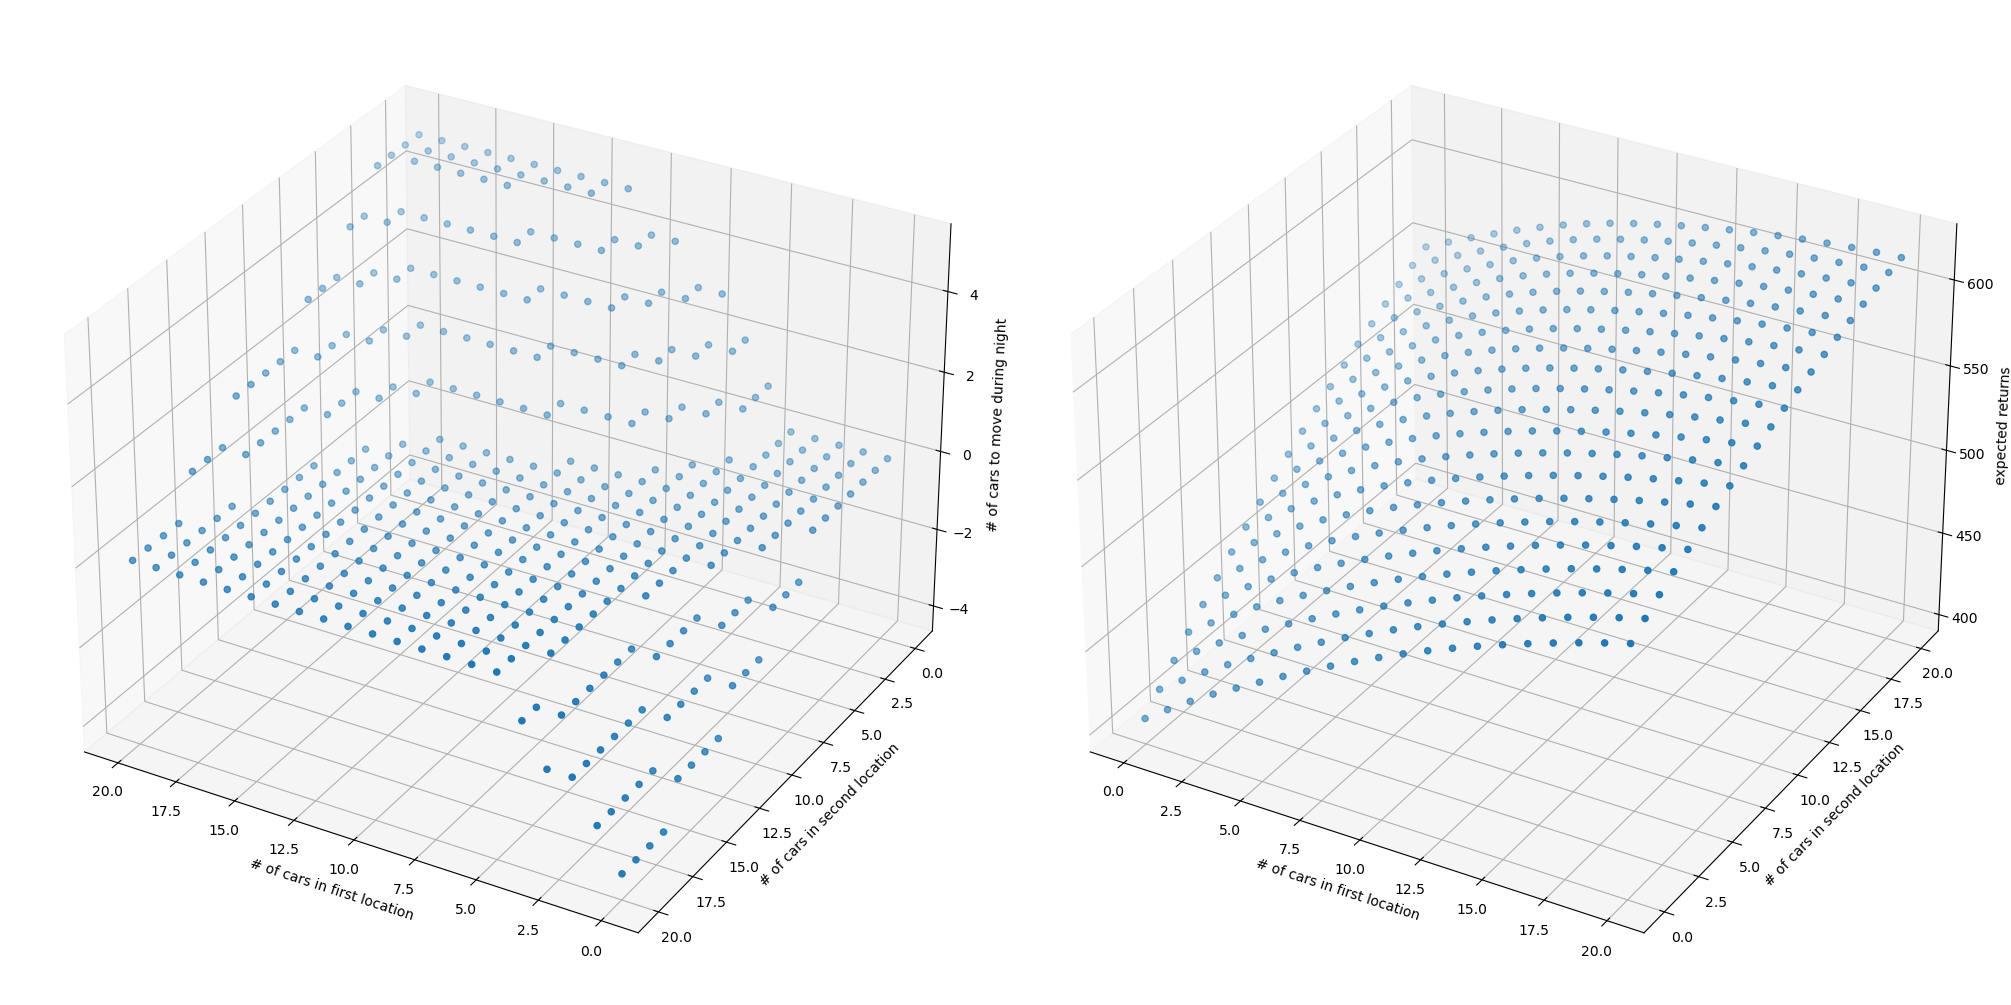

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(20,10), layout="constrained")
ax = fig.add_subplot(1,2,1, projection='3d')

m = 'o'

cars_loc1 = []
cars_loc2 = []
policy_list = []
value_list = []

for i,j in states:
    cars_loc1.append(i)
    cars_loc2.append(j)
    policy_list.append(policy[i,j])
    value_list.append(stateVal[i,j])

ax.scatter(cars_loc1, cars_loc2, policy_list, marker=m)

ax.set_xlabel('# of cars in first location')
ax.set_ylabel('# of cars in second location')
ax.set_zlabel('# of cars to move during night')

ax.xaxis.set_inverted(True)
ax.yaxis.set_inverted(True)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(cars_loc1, cars_loc2, value_list, marker=m)

ax2.set_xlabel('# of cars in first location')
ax2.set_ylabel('# of cars in second location')
ax2.set_zlabel('expected returns')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

plt.show()

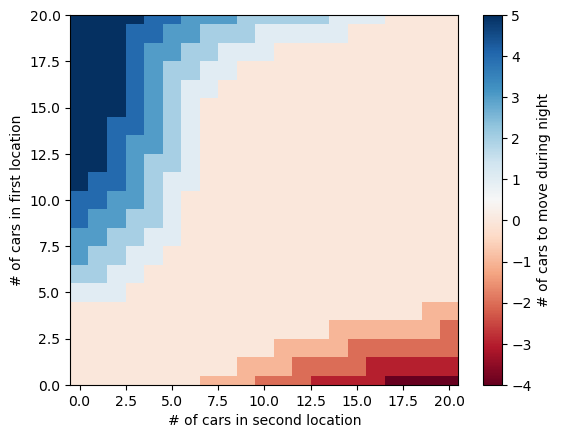

In [99]:
plt.imshow(policy, cmap='RdBu', interpolation='nearest')
plt.ylim([0,20])
cbar = plt.colorbar()
cbar.set_label('# of cars to move during night', rotation=90)


plt.xlabel("# of cars in second location")
plt.ylabel("# of cars in first location")
plt.show()